In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


## Setup: una muestra aleatoria

In [3]:
n = 10000
mu = np.array([3, -2, 2])
sigma = np.array([[1, 0.8, -0.2], [0.8, 1, -0.4], [-0.2, -0.4, 1]]) * 16
# mu = np.array([1,2])
# sigma = np.array([[1, 0.8],[0.8, 1]]) * 16
X = sp.stats.multivariate_normal(mu, sigma).rvs(size=n)

In [4]:
X.shape

(10000, 3)

In [5]:
X.mean(axis=0)

array([ 3.00783816, -1.98929573,  2.04113568])

In [6]:
means = {}
covs = {}
for n in np.logspace(1, 4, 16).astype(int):
    means[n] = np.mean(X[:n], axis=0)
    covs[n] = np.cov(X[:n], rowvar=False)
means = pd.DataFrame(means).T

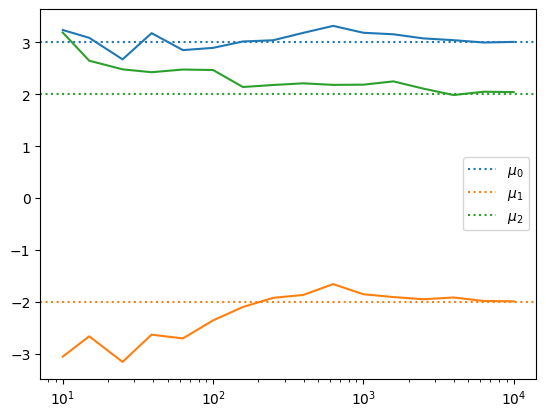

In [7]:
plt.plot(means), plt.xscale("log")
for idx, mu_idx in enumerate(mu):
    plt.axhline(mu_idx, linestyle="dotted", label=f"$\\mu_{idx}$", c=f"C{idx}")
plt.legend()

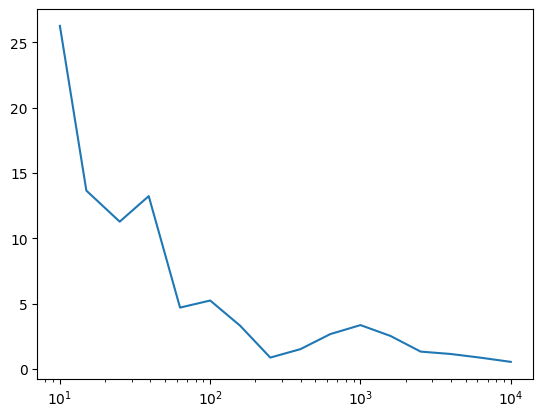

(None, None)

In [8]:
def dist(X, Y):
    return np.sqrt(((X - Y) ** 2).sum())


dists = pd.Series({n: dist(cov, sigma) for n, cov in covs.items()})
dists.plot()
plt.xscale("log"), plt.show()

In [9]:
def covhat(X):
    X_ = X - X.mean(axis=0)
    n = X.shape[0]
    return X_.T @ X_ / (n - 1)


Sigma = covhat(X)

# Descomposiciones de Matrices
## Valores Singulares (`sp.linalg.svd`)

In [10]:
help(sp.linalg.svd)

Help on function svd in module scipy.linalg._decomp_svd:

svd(a, full_matrices=True, compute_uv=True, overwrite_a=False, check_finite=True, lapack_driver='gesdd')
    Singular Value Decomposition.
    
    Factorizes the matrix `a` into two unitary matrices ``U`` and ``Vh``, and
    a 1-D array ``s`` of singular values (real, non-negative) such that
    ``a == U @ S @ Vh``, where ``S`` is a suitably shaped matrix of zeros with
    main diagonal ``s``.
    
    Parameters
    ----------
    a : (M, N) array_like
        Matrix to decompose.
    full_matrices : bool, optional
        If True (default), `U` and `Vh` are of shape ``(M, M)``, ``(N, N)``.
        If False, the shapes are ``(M, K)`` and ``(K, N)``, where
        ``K = min(M, N)``.
    compute_uv : bool, optional
        Whether to compute also ``U`` and ``Vh`` in addition to ``s``.
        Default is True.
    overwrite_a : bool, optional
        Whether to overwrite `a`; may improve performance.
        Default is False.
   

In [11]:
Sigma.round(2)

array([[15.9 , 12.85, -3.56],
       [12.85, 16.04, -6.52],
       [-3.56, -6.52, 16.05]])

In [12]:
U, s, Vh = sp.linalg.svd(Sigma)
S = np.diag(s)

In [13]:
U.round(2)

array([[-0.62,  0.42, -0.66],
       [-0.67,  0.16,  0.73],
       [ 0.41,  0.89,  0.18]])

In [14]:
s.round(2)

array([32.03, 13.22,  2.75])

In [15]:
Vh.round(2)

array([[-0.62, -0.67,  0.41],
       [ 0.42,  0.16,  0.89],
       [-0.66,  0.73,  0.18]])

Por ser simétrica, sus VVSS a izquierda y derecha son los mismos (hasta un cambio de sentido).

In [16]:
for i in range(U.shape[1]):
    assert np.allclose(U[:, i], Vh[i, :]) or np.allclose(U[:, i], -Vh[i, :])

In [17]:
assert np.allclose(Sigma, U @ S @ Vh)

## Autovalores y Autovectores (`sp.linalg.eigh`)

In [18]:
help(sp.linalg.eigh)

Help on function eigh in module scipy.linalg._decomp:

eigh(a, b=None, *, lower=True, eigvals_only=False, overwrite_a=False, overwrite_b=False, turbo=<object object at 0x0000027BC186F9D0>, eigvals=<object object at 0x0000027BC186F9D0>, type=1, check_finite=True, subset_by_index=None, subset_by_value=None, driver=None)
    Solve a standard or generalized eigenvalue problem for a complex
    Hermitian or real symmetric matrix.
    
    Find eigenvalues array ``w`` and optionally eigenvectors array ``v`` of
    array ``a``, where ``b`` is positive definite such that for every
    eigenvalue λ (i-th entry of w) and its eigenvector ``vi`` (i-th column of
    ``v``) satisfies::
    
                      a @ vi = λ * b @ vi
        vi.conj().T @ a @ vi = λ
        vi.conj().T @ b @ vi = 1
    
    In the standard problem, ``b`` is assumed to be the identity matrix.
    
    Parameters
    ----------
    a : (M, M) array_like
        A complex Hermitian or real symmetric matrix whose eigenval

In [19]:
w, V = sp.linalg.eigh(Sigma)

In [20]:
w.round(2)

array([ 2.75, 13.22, 32.03])

In [21]:
V.round(2)

array([[ 0.66,  0.42, -0.62],
       [-0.73,  0.16, -0.67],
       [-0.18,  0.89,  0.41]])

In [22]:
w = w[::-1]  # np.flip(w, axis=0)
V = V[:, ::-1]  # np.flip(V, axis=1)
w.round(2), V.round(2)

(array([32.03, 13.22,  2.75]),
 array([[-0.62,  0.42,  0.66],
        [-0.67,  0.16, -0.73],
        [ 0.41,  0.89, -0.18]]))

In [23]:
assert np.allclose(Sigma, V @ np.diag(w) @ V.T)

Como la matrix es simétrica y positiva definida, los valores singulares coinciden con los autovalores, y los vectores singulares coinciden con los autovectores (hasta un cambio de sentido).

In [24]:
assert np.allclose(s, w)
for i in range(U.shape[1]):
    assert np.allclose(U[:, i], V[:, i]) or np.allclose(U[:, i], -V[:, i])

## Análisis de Componentes Principales (PCA)

In [25]:
pca = PCA().fit(X)
pca.explained_variance_.round(2), pca.components_.round(2)

(array([32.03, 13.22,  2.75]),
 array([[ 0.62,  0.67, -0.41],
        [-0.42, -0.16, -0.89],
        [-0.66,  0.73,  0.18]]))

In [26]:
class Perro:

    def __init__(self, nombre="Fido"):
        self.nombre = nombre

    
    def ladrar(self):
        print(f"Guau! Soy {self.nombre}")


In [27]:
w.round(2), V.round(2)

(array([32.03, 13.22,  2.75]),
 array([[-0.62,  0.42,  0.66],
        [-0.67,  0.16, -0.73],
        [ 0.41,  0.89, -0.18]]))

In [28]:
assert np.allclose(pca.explained_variance_, w)
for i in range(pca.components_.shape[0]):
    assert np.allclose(pca.components_[i], V[:, i]) or np.allclose(
        pca.components_[i], -V[:, i]
    )

In [29]:
PCA(2).fit(X)

PCA(n_components=2)

# Implementando de cero: `miPCA`
Antes de un parcial, no hay mejor manera de asentar un conocimiento que explicándoselo a un amigx. Antes de una clase, no hay mejor manera de comprender un programa que reproduciéndolo independientemente.

In [30]:
# PCA: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# Ej. Transformer: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html

class miPCA:

    def __init__(self, n_components=1.0):
        self.n_components = n_components

    def fit(self, X):
        self.media_ = X.mean(axis=0)
        X_ = X - self.media_
        self.cov_ = X_.T @ X_ / (X.shape[0] - 1)
        w, V = sp.linalg.eigh(self.cov_)
        self.explained_variance_ = w[::-1]
        total_variance = self.explained_variance_.sum()
        if isinstance(self.n_components, int):
            self.n_components_ = np.clip(self.n_components, 0, X.shape[1])
        elif isinstance(self.n_components, float):
            min_ratio = np.clip(0.0, self.n_components, 1.0)
            cum_ratios = self.explained_variance_.cumsum() / total_variance
            self.n_components_ = (cum_ratios >= min_ratio).argmax() + 1
        else:
            raise ValueError("n_components debe ser un `int` o `float`")
        self.components_ = V[:, ::-1].T[: self.n_components_]
        self.explained_variance_ = self.explained_variance_[: self.n_components_]
        self.explained_variance_ratio_ = self.explained_variance_ / total_variance
        return self


    def transform(self, X):
        return (X - self.media_) @ self.components_.T
    

    def inverse_transform(self, Z):
        return self.media_ + Z @ self.components_

In [31]:
n_components = 1.0 - 1e-9
su_pca = PCA(n_components).fit(X)
mi_pca = miPCA(n_components).fit(X)

In [32]:
assert np.allclose(su_pca.explained_variance_, mi_pca.explained_variance_)
for i in range(su_pca.components_.shape[0]):
    assert np.allclose(su_pca.components_[i], mi_pca.components_[i]) or np.allclose(
        su_pca.components_[i], -mi_pca.components_[i]
    )
    

In [33]:
suZ = su_pca.transform(X)
miZ = mi_pca.transform(X)
for i in range(suZ.shape[1]):
    assert np.allclose(suZ[:, i], miZ[:, i]) or np.allclose(suZ[:, i], -miZ[:, i])

In [34]:
suXrecu = su_pca.inverse_transform(suZ)
miXrecu = mi_pca.inverse_transform(miZ)
assert np.allclose(suXrecu, miXrecu)

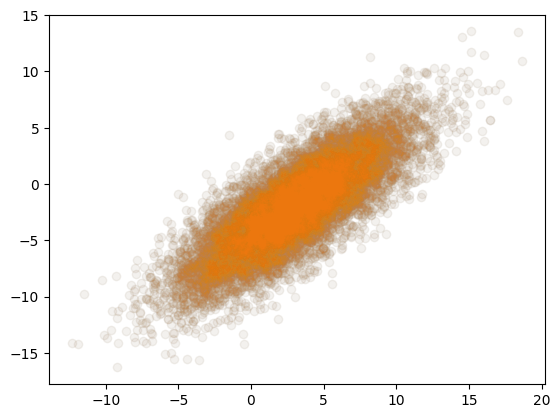

In [35]:
plt.scatter(X[:,0],X[:,1], alpha=0.05)
plt.scatter(suXrecu[:,0],suXrecu[:,1], alpha=0.05)

## Un ejemplo: análisis de espectrometrías

In [36]:
import os

os.getcwd()

'c:\\Users\\luciomaspero\\Desktop\\Trabajos\\Personales\\LaboDeDatos\\Clase-19'

In [37]:
data_dir = "../Datos/"
dfx = pd.read_csv(data_dir + "glass-espectros.csv").rename(columns={"Unnamed: 0": "id"})


In [38]:
dfx.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V741,V742,V743,V744,V745,V746,V747,V748,V749,V750
0,1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,40.80,38.40,41.80,41.80,50.60,42.80,47.00,40.6,41.6,41.6
1,2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,41.60,43.60,42.40,39.60,42.80,43.20,44.80,43.8,44.4,37.2
2,3,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,50.60,41.00,45.60,47.80,47.00,44.20,49.80,40.6,40.4,42.0
3,4,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,45.75,45.75,42.75,40.75,42.75,46.25,49.25,46.5,47.0,42.5
4,5,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,42.20,41.40,39.60,44.80,43.00,44.40,45.60,43.4,40.0,40.6


In [39]:
data = dfx.melt(id_vars="id", var_name="freq", value_name="ampl")
data["freq"] = data.freq.str.replace("V", "").astype(int)
data["id"] = data.id.astype("str")

<Axes: xlabel='freq', ylabel='ampl'>

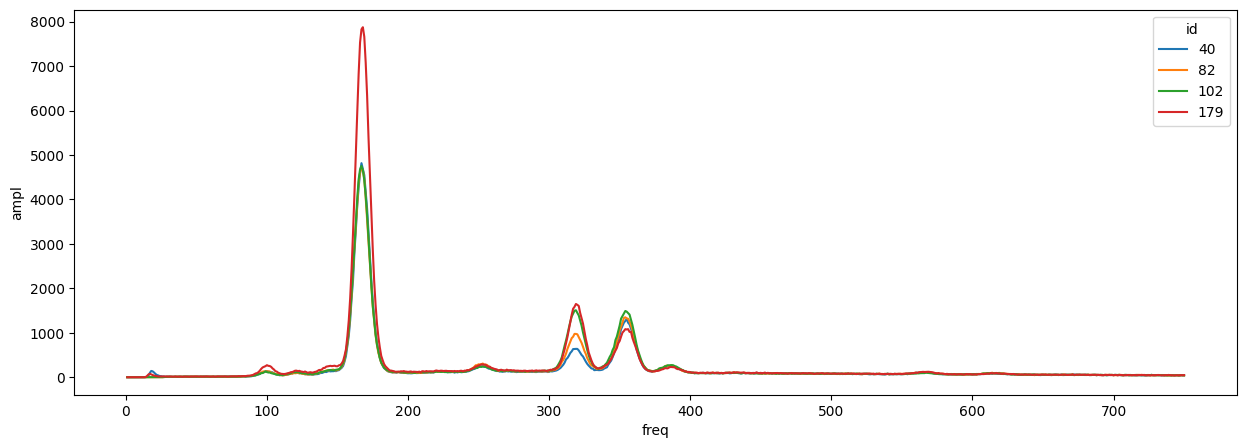

In [40]:
espectros = ["82", "40", "102", "179"]
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(
    data[data.id.isin(espectros)],
    x="freq",
    y="ampl",
    hue="id",
)

<Axes: xlabel='freq', ylabel='ampl'>

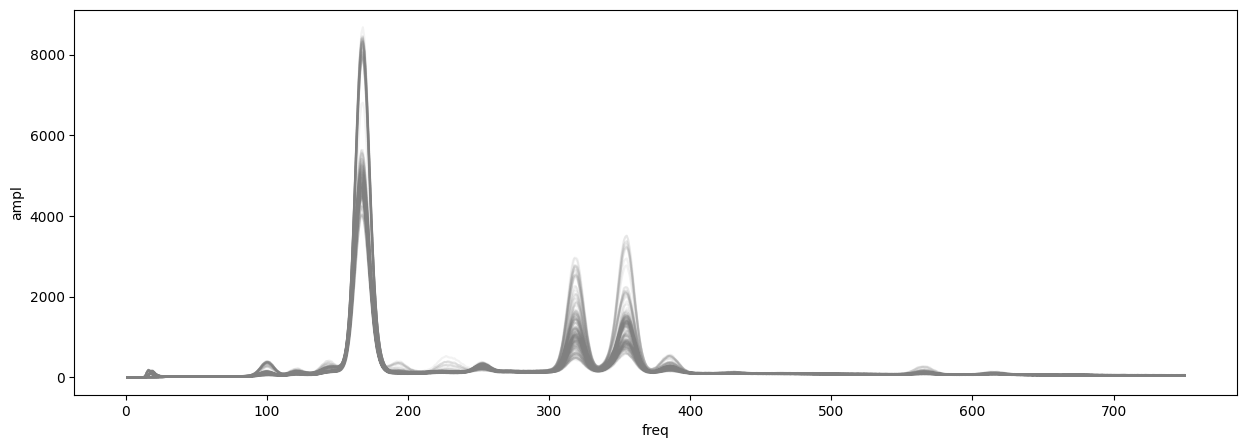

In [41]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(
    data=data, x="freq", y="ampl", units="id", estimator=None, color="gray", alpha=0.1
)

In [42]:
mx = dfx.drop(columns="id")
pca_mx = PCA(0.9).fit(mx)

In [43]:
pca_mx.components_.shape

(3, 750)

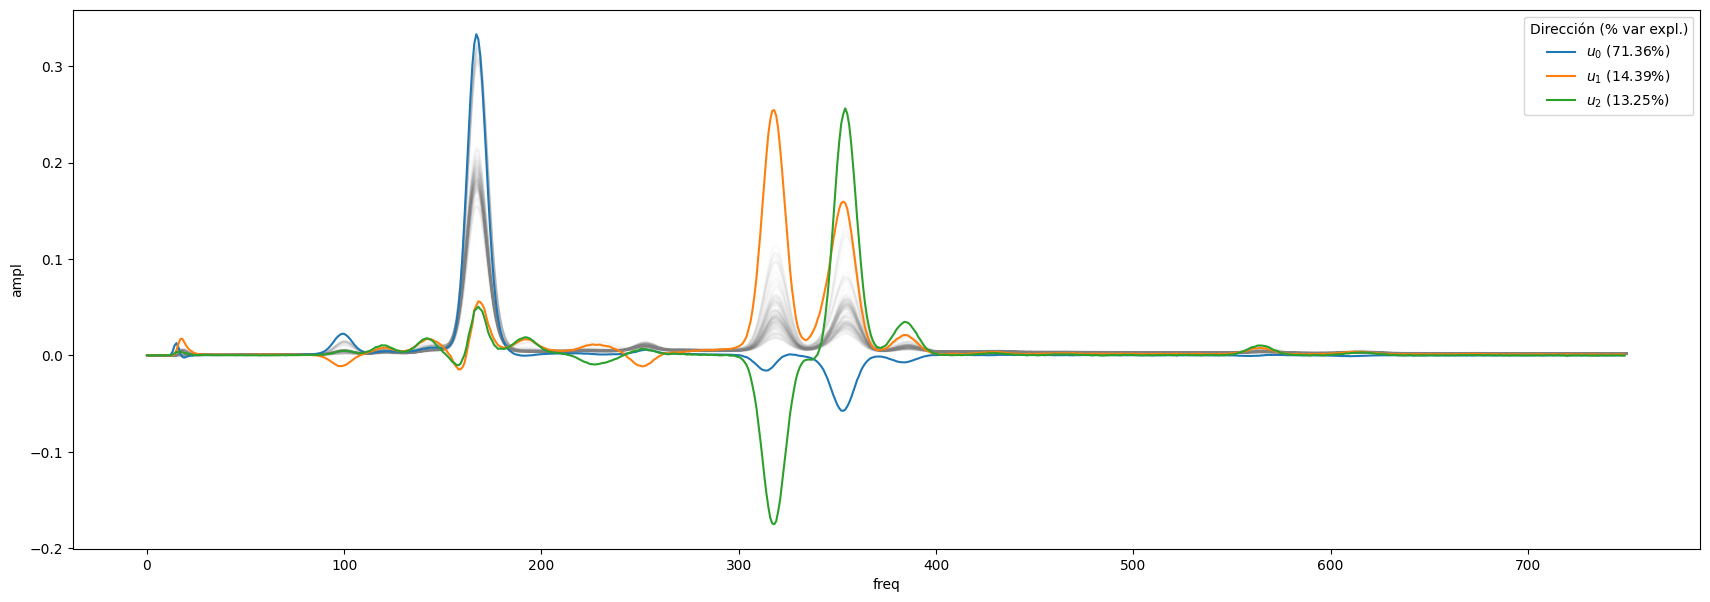

In [44]:
fig, ax = plt.subplots(figsize=(21, 7))

_data = data.copy()
_data.ampl *= pca_mx.components_.max() / _data.ampl.max()
sns.lineplot(
    data=_data,
    x="freq",
    y="ampl",
    units="id",
    estimator=None,
    color="gray",
    alpha=0.021,
    ax=ax,
)
for i in range(pca_mx.n_components_):
    ax.plot(pca_mx.components_[i, :], label=f"$u_{i}$ ({pca_mx.explained_variance_ratio_[i]*100:.2f}%)")
plt.legend(title="Dirección (% var expl.)")

In [45]:
mx_recu = pca_mx.inverse_transform(pca_mx.transform(mx))
mx_recu.shape

(180, 750)

In [46]:
dfx_recu = pd.DataFrame()
dfx_recu["id"] = dfx.id
dfx_recu.loc[:, dfx.columns[1:]] = mx_recu
dfx_recu.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V741,V742,V743,V744,V745,V746,V747,V748,V749,V750
0,1,0.1,0.1,0.101873,0.101143,0.1,0.1,0.101129,0.1,0.1,...,43.439879,43.160459,43.040773,43.327774,43.391752,42.855510,43.075766,42.485385,42.347183,42.512296
1,2,0.1,0.1,0.101786,0.101194,0.1,0.1,0.100987,0.1,0.1,...,43.563810,43.260426,43.133505,43.419941,43.526617,42.928656,43.183643,42.603677,42.475795,42.604060
2,3,0.1,0.1,0.101740,0.101450,0.1,0.1,0.100544,0.1,0.1,...,43.736176,43.546918,43.263062,43.810465,43.810232,43.263606,43.500478,42.833463,42.581520,42.641594
3,4,0.1,0.1,0.101743,0.101402,0.1,0.1,0.100631,0.1,0.1,...,43.720816,43.520479,43.252569,43.764350,43.775801,43.241923,43.466434,42.813380,42.577521,42.644151
4,5,0.1,0.1,0.102081,0.101052,0.1,0.1,0.101399,0.1,0.1,...,43.124190,42.881610,42.801417,43.077891,43.057139,42.603223,42.787375,42.171056,42.017249,42.277926


In [47]:
data_recu = dfx_recu.melt(id_vars="id", var_name="freq", value_name="ampl")
data_recu["freq"] = data_recu.freq.str.replace("V", "").astype(int)
data_recu["id"] = data_recu.id.astype("str")

<Axes: xlabel='freq', ylabel='ampl'>

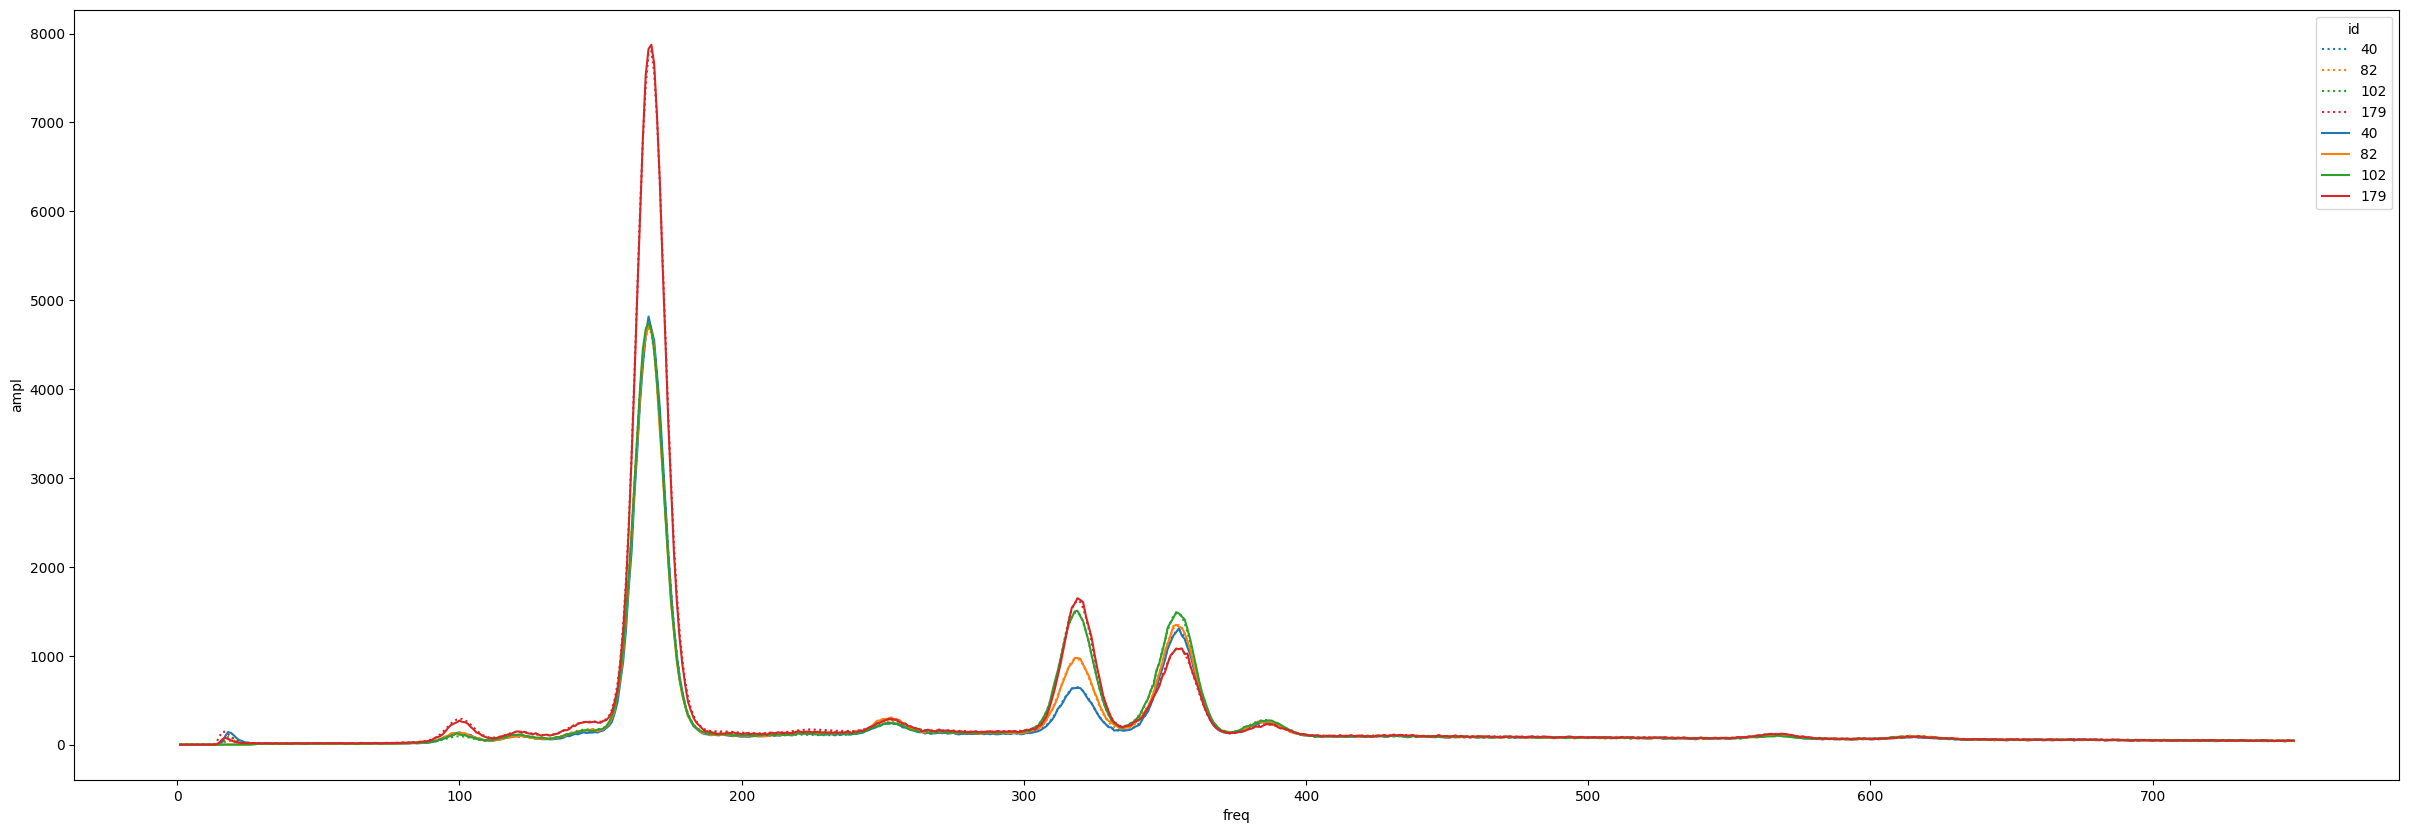

In [48]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.lineplot(
    data_recu[data_recu.id.isin(espectros)],
    x="freq",
    y="ampl",
    hue="id",
    linestyle="dotted",
    ax=ax,
)
sns.lineplot(
    data[data.id.isin(espectros)],
    x="freq",
    y="ampl",
    hue="id",
    ax=ax,
)
# plt.yscale("log")

## Imágenes

In [49]:
jupiter = mpl.image.imread("jupiter.webp")

FileNotFoundError: [Errno 2] No such file or directory: 'jupiter.webp'

In [ ]:
jupiter.shape

(1102, 1102, 3)

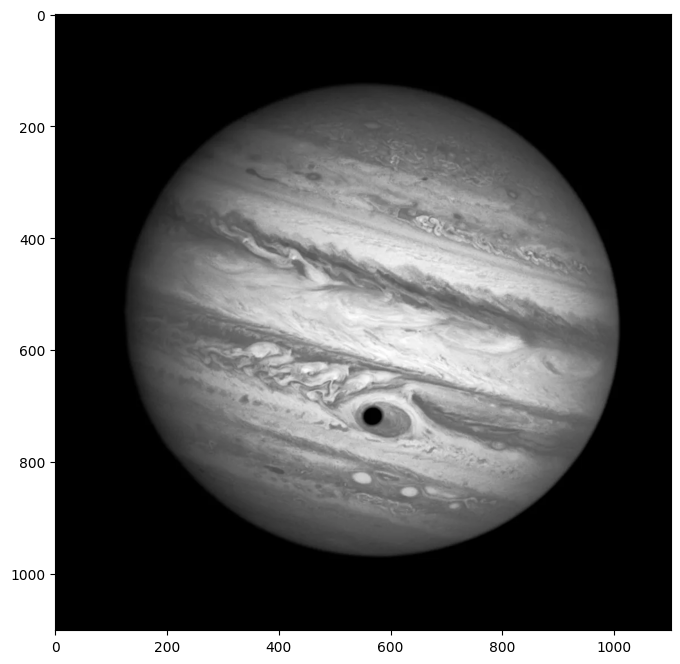

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(jupiter)

In [ ]:
import numpy as np


def rgb2gray(rgb):

    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [ ]:
jupiter_gris = rgb2gray(jupiter)
jupiter_gris.shape

(1102, 1102)

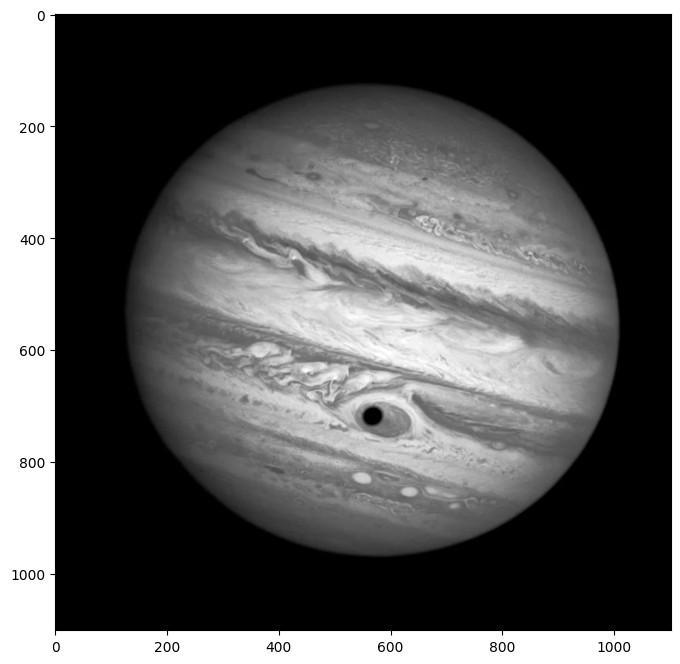

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.imshow(jupiter_gris, cmap="gray")

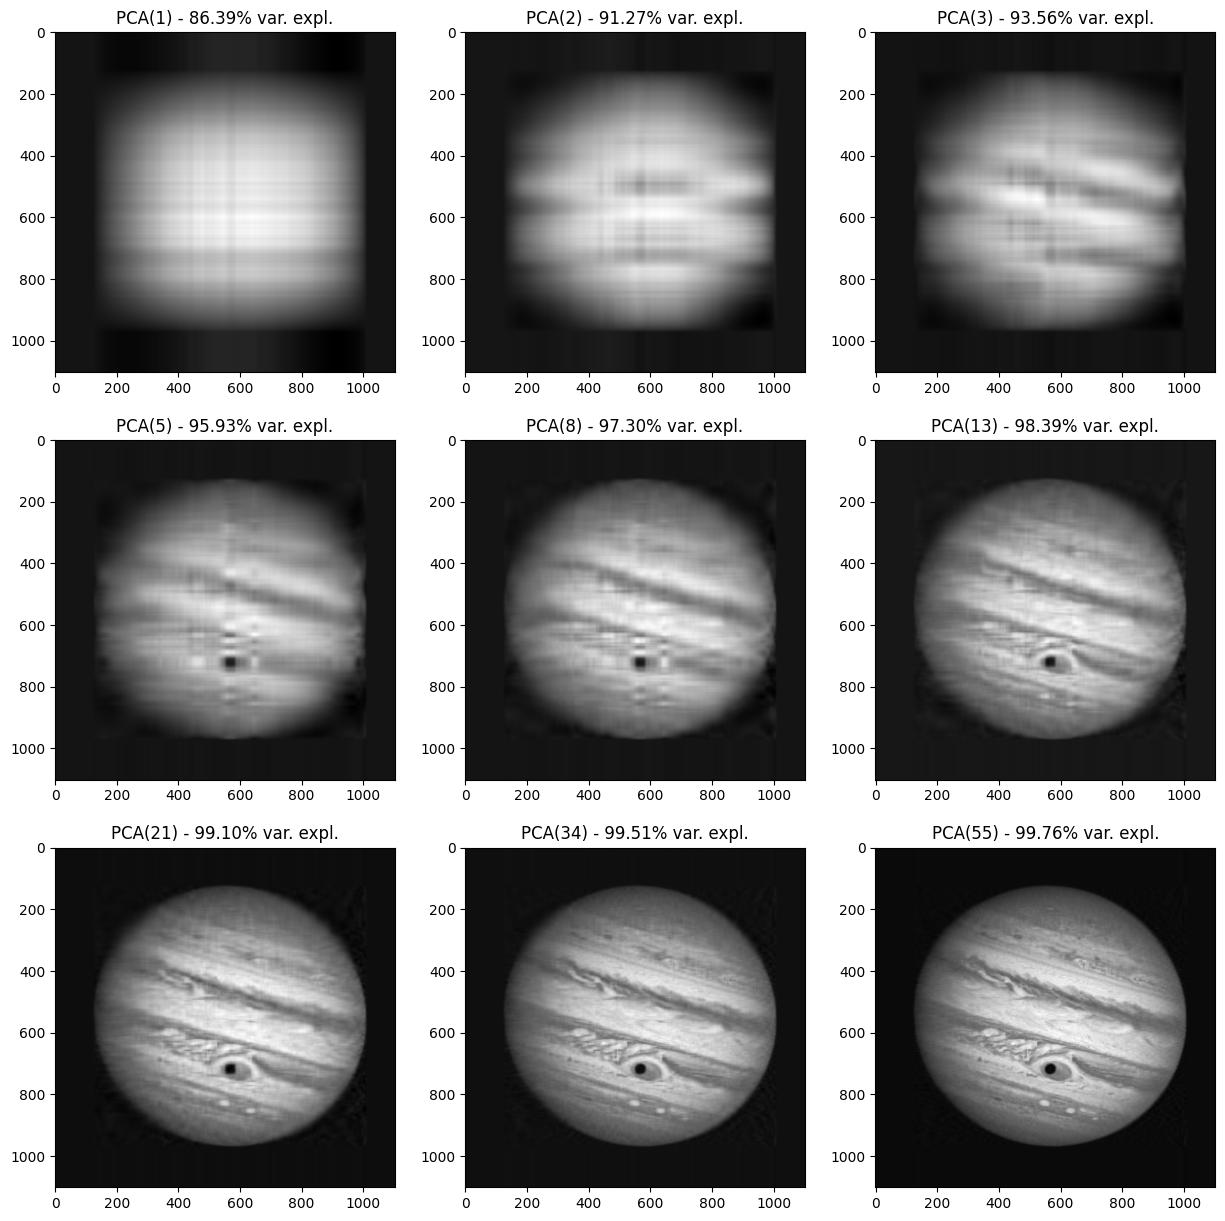

In [ ]:
pcas = {}
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
# porcentajes_compresion = [0.85, 0.9, 0.95, 0.99, 0.995, 0.999, 0.9995, 0.9999]
n_direcciones = [1, 2, 3, 5, 8, 13, 21, 34, 55]
for n_dirs, ax in zip(n_direcciones, axs.flatten()):
    pcas[n_dirs] = pca = PCA(n_dirs).fit(jupiter_gris)
    ax.imshow(pca.inverse_transform(pca.transform(jupiter_gris)), cmap="gray")
    var_expl = pca.explained_variance_ratio_.sum()
    ax.set_title(
        f"PCA({n_dirs}) - {(var_expl * 100):.2f}% var. expl."
    )

## Imágenes en colores

In [ ]:
unicornio = mpl.image.imread("unicornio.jpeg")

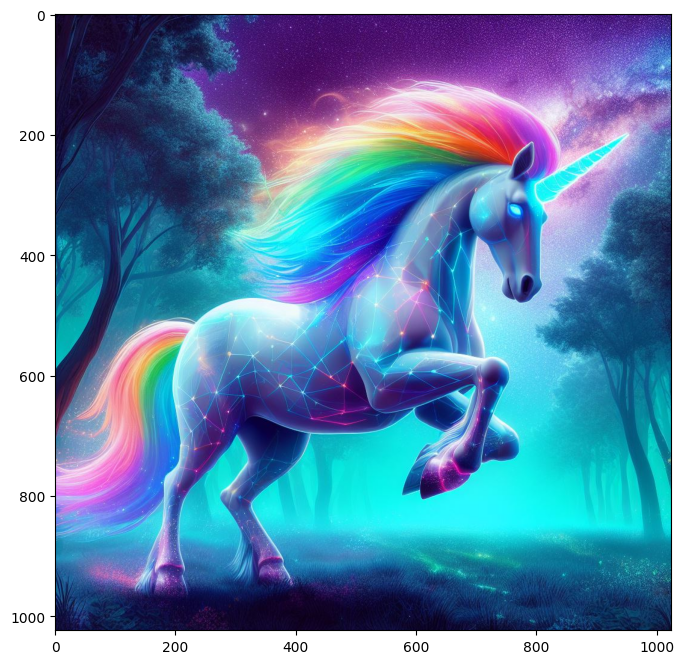

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(unicornio)

In [ ]:
n_components = 0.95
pcas_color = {
    capa: PCA(n_components).fit(unicornio[:, :, capa])
    for capa in range(unicornio.shape[2])
}

In [ ]:
capas_recuperadas = {
    capa: pca.inverse_transform(pca.transform(unicornio[:, :, capa]))
    for capa, pca in pcas_color.items()
}

In [ ]:
unicornio_recu = np.stack(list(capas_recuperadas.values()), axis=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


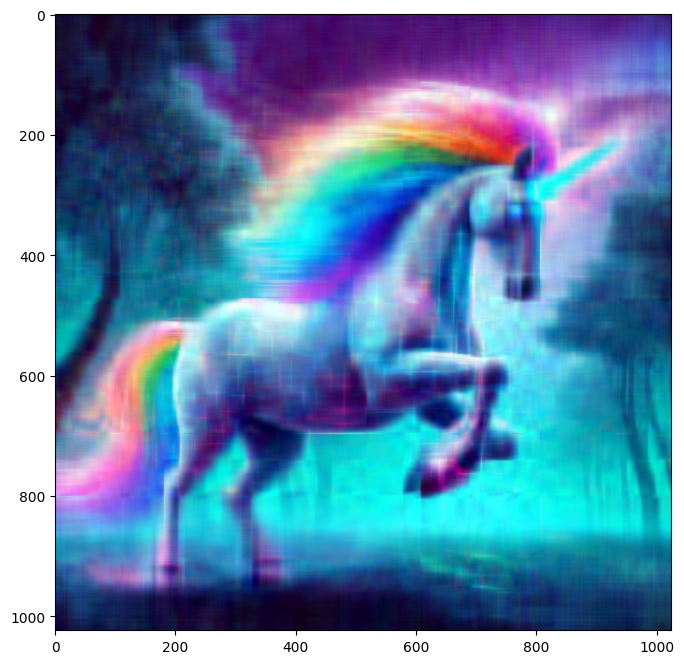

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(unicornio_recu.astype(int))

In [ ]:
{i: pca.n_components_ for i, pca in pcas_color.items()}

{0: 22, 1: 20, 2: 22}

## Y volvemos a la estadística

In [ ]:
pca = PCA(1).fit(X)

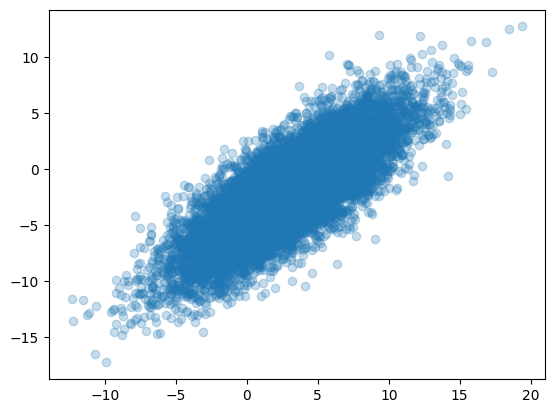

In [ ]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.25, label="original")


In [ ]:
pca.inverse_transform(pca.transform(X)).shape

(10000, 3)

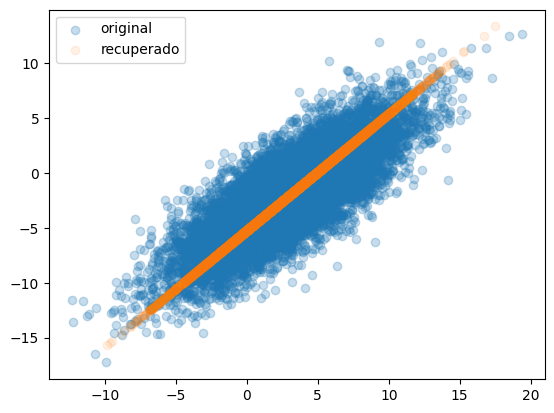

In [ ]:
X_recu = pca.inverse_transform(pca.transform(X))
plt.scatter(X[:, 0], X[:, 1], alpha=0.25, label="original")
plt.scatter(X_recu[:, 0], X_recu[:, 1], alpha=0.1, label="recuperado")
plt.legend()